In [27]:
!git push 

[master 809be2f] asd
 3 files changed, 5026 insertions(+), 1411 deletions(-)
 rewrite fish-classification/landmarks_localization_data_preparation.ipynb (60%)
 create mode 100644 fish-classification/landmarks_localization_vgg16_stage2.ipynb


In [11]:
#import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import os
from sklearn.model_selection import train_test_split


import json
import numpy as np
import pandas as pd
from sklearn import preprocessing
import os
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.image as mpimg
from  matplotlib import pyplot
import cv2
import random
from PIL import Image
from sklearn.utils import class_weight
import numpy
import codecs

In [2]:
!pip install xmltodict

You are using pip version 9.0.3, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import xmltodict, json
landmark_annotations = os.listdir('lobster_uk_landmarks')
import imgaug as ia
from imgaug import augmenters as iaa
import math

In [12]:
def load(path):
    """takes as input the path to a .pts and returns a list of 
    tuples of floats containing the points in in the form:
    [(x_0, y_0, z_0),
     (x_1, y_1, z_1),
    ...
     (x_n, y_n, z_n)]"""
    with codecs.open(path, 'r', encoding='utf-8') as f:
        rows = [rows.strip() for rows in f]
    
    """Use the curly braces to find the start and end of the point data""" 
    head = rows.index('{') + 1
    tail = rows.index('}')

    """Select the point data split into coordinates"""
    raw_points = rows[head:tail]
    coords_set = [point.split() for point in raw_points]

    """Convert entries from lists of strings to tuples of floats"""
    points = [tuple([float(point) for point in coords]) for coords in coords_set]
    return points

In [5]:
def process_image_keypoints(img,rectangle_points,bbox_coords):
    desired_size = 448

    old_size = img.shape

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format

    im = cv2.resize(img, (new_size[1], new_size[0]))

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
        value=color)

    point_list = rectangle_points
    rects = []
    for a,b in point_list:
        a = a*ratio
        b = b*ratio
        rects.append([a+left,b+top])
    bbox_coordinates = []
    for a,b in bbox_coords:
        a = float(a)*ratio
        b = float(b)*ratio
        bbox_coordinates.append([a+left,b+top])
    return new_im,rects,bbox_coordinates

In [14]:
count_correct = 0
count_wrong = 0
labels =  []
images = []
bb = []
bboxes = []
image_sizes = []
image_names = []
bb_sizes = []
landmarks =  []
for file in os.listdir("lobster_uk_landmarks/"):
    try:
        if file.endswith(".pts"):
                image_name = file.split("_imglab.pts")[0]
                path = 'lobster_uk/'+image_name
                bgr_img = cv2.imread(path)
                print(path)
                img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
                path = 'lobster_uk_landmarks/'+file
                points = load(path)
                print('lobster_uk_bboxes/'+image_name.split(".")[0]+'.xml')
                with open('lobster_uk_bboxes/'+image_name.split(".")[0]+'.xml','r') as f:
                    text = f.read()
                    d = xmltodict.parse(text)
                obj = d['annotation']['object'][0] if isinstance(d['annotation']['object'],list) else d['annotation']['object']
                bbox = obj['bndbox']                
                bbox_coords = [(bbox['xmin'],bbox['ymin']),(bbox['xmax'],bbox['ymax'])]
                
                img,rectange_points,bbox_coords = process_image_keypoints(img,points,bbox_coords)

                keypoints = []
                for x,y in rectange_points:
                        keypoints.append(ia.Keypoint(x=x, y=y))
                
                bbs = ia.BoundingBoxesOnImage([
                    ia.BoundingBox(x1=bbox_coords[0][0], y1=bbox_coords[0][1], x2=bbox_coords[1][0], y2=bbox_coords[1][1])
                ], shape=img.shape)
                
                images.append(img)
                landmarks.append(ia.KeypointsOnImage(keypoints, shape=img.shape))
                bboxes.append(bbs)
                image_names.append(file)
                #labels.append(obj['name'])
                #bb_sizes.append((w,h))
                #bboxes_rot.append([w,h,cx,cy,angle])
                image_sizes.append((float(d['annotation']['size']['width']),float(d['annotation']['size']['height'])))
                count_correct += 1
    except Exception as ex:
        print(ex)
        count_wrong += 1

lobster_uk/P8220220.JPG
lobster_uk_bboxes/P8220220.xml
lobster_uk/P8080059.JPG
lobster_uk_bboxes/P8080059.xml
lobster_uk/PC190092.JPG
lobster_uk_bboxes/PC190092.xml
lobster_uk/PC190228.JPG
lobster_uk_bboxes/PC190228.xml
lobster_uk/P8080166.JPG
lobster_uk_bboxes/P8080166.xml
lobster_uk/PC190205.JPG
lobster_uk_bboxes/PC190205.xml
lobster_uk/P8220180.JPG
lobster_uk_bboxes/P8220180.xml
lobster_uk/P8080065.JPG
lobster_uk_bboxes/P8080065.xml
lobster_uk/PC190093.JPG
lobster_uk_bboxes/PC190093.xml
lobster_uk/P8080110.JPG
lobster_uk_bboxes/P8080110.xml
lobster_uk/P8080132.JPG
lobster_uk_bboxes/P8080132.xml
lobster_uk/P8220208.JPG
lobster_uk_bboxes/P8220208.xml
lobster_uk/P8080102.JPG
lobster_uk_bboxes/P8080102.xml
lobster_uk/PC190239.JPG
lobster_uk_bboxes/PC190239.xml
lobster_uk/PC190140.JPG
lobster_uk_bboxes/PC190140.xml
lobster_uk/PC190255.JPG
lobster_uk_bboxes/PC190255.xml
lobster_uk/P8220188.JPG
lobster_uk_bboxes/P8220188.xml
lobster_uk/PC190147.JPG
lobster_uk_bboxes/PC190147.xml
lobster_uk

lobster_uk/PC190321.JPG
lobster_uk_bboxes/PC190321.xml
lobster_uk/P8080019.JPG
lobster_uk_bboxes/P8080019.xml
lobster_uk/P8080152.JPG
lobster_uk_bboxes/P8080152.xml
lobster_uk/P8220178.JPG
lobster_uk_bboxes/P8220178.xml
lobster_uk/P8220210.JPG
lobster_uk_bboxes/P8220210.xml
lobster_uk/P8220198.JPG
lobster_uk_bboxes/P8220198.xml
lobster_uk/P8080051.JPG
lobster_uk_bboxes/P8080051.xml
lobster_uk/P8080091.JPG
lobster_uk_bboxes/P8080091.xml
lobster_uk/P8080030.JPG
lobster_uk_bboxes/P8080030.xml
lobster_uk/P8220159.JPG
lobster_uk_bboxes/P8220159.xml
lobster_uk/P8220222.JPG
lobster_uk_bboxes/P8220222.xml
lobster_uk/P8080063.JPG
lobster_uk_bboxes/P8080063.xml
lobster_uk/P8080045.JPG
lobster_uk_bboxes/P8080045.xml
lobster_uk/PC190086.JPG
lobster_uk_bboxes/PC190086.xml
lobster_uk/P8080108.JPG
lobster_uk_bboxes/P8080108.xml
lobster_uk/P8080151.JPG
lobster_uk_bboxes/P8080151.xml
lobster_uk/PC190143.JPG
lobster_uk_bboxes/PC190143.xml
lobster_uk/PC190225.JPG
lobster_uk_bboxes/PC190225.xml
lobster_uk

lobster_uk/P8080099.JPG
lobster_uk_bboxes/P8080099.xml
lobster_uk/PC190145.JPG
lobster_uk_bboxes/PC190145.xml
lobster_uk/P8080122.JPG
lobster_uk_bboxes/P8080122.xml
lobster_uk/P8080074.JPG
lobster_uk_bboxes/P8080074.xml
lobster_uk/P8080053.JPG
lobster_uk_bboxes/P8080053.xml
lobster_uk/P8220171.JPG
lobster_uk_bboxes/P8220171.xml
lobster_uk/PC190100.JPG
lobster_uk_bboxes/PC190100.xml
lobster_uk/P8220190.JPG
lobster_uk_bboxes/P8220190.xml
lobster_uk/P8080087.JPG
lobster_uk_bboxes/P8080087.xml
lobster_uk/PC190101.JPG
lobster_uk_bboxes/PC190101.xml
lobster_uk/P8220196.JPG
lobster_uk_bboxes/P8220196.xml
lobster_uk/PC190144.JPG
lobster_uk_bboxes/PC190144.xml
lobster_uk/P8220165.JPG
lobster_uk_bboxes/P8220165.xml
lobster_uk/PC190138.JPG
lobster_uk_bboxes/PC190138.xml
lobster_uk/P8080129.JPG
lobster_uk_bboxes/P8080129.xml
lobster_uk/P8080069.JPG
lobster_uk_bboxes/P8080069.xml
lobster_uk/P8080130.JPG
lobster_uk_bboxes/P8080130.xml
lobster_uk/P8080043.JPG
lobster_uk_bboxes/P8080043.xml
lobster_uk

In [15]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.5), # vertically flip 50% of all images
        # crop images by -5% to 10% of their height/width
        #sometimes(iaa.CropAndPad(
        #    percent=(-0.05, 0.1),
        #    pad_mode=ia.ALL,
        #    pad_cval=(0, 255)
        #)),
        sometimes(iaa.Affine(
            #scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            #shear=(-16, 16), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 5),
            [
                #sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                #iaa.OneOf([
                #    iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                #    iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                #    iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                #]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                #iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                # search either for all edges or for directed edges,
                # blend the result with the original image using a blobby mask
                #iaa.SimplexNoiseAlpha(iaa.OneOf([
                #    iaa.EdgeDetect(alpha=(0.5, 1.0)),
                #    iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                #])),
                #iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                #iaa.OneOf([
                #    iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                #    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                #]),
                #iaa.Invert(0.05, per_channel=True), # invert color channels
                iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                #iaa.AddToHueAndSaturation((-10, 20)), # change hue and saturation
                # either change the brightness of the whole image (sometimes
                # per channel) or change the brightness of subareas
                iaa.OneOf([
                    #iaa.Multiply((0.5, 1.5), per_channel=0.5),
                    #iaa.FrequencyNoiseAlpha(
                    #    exponent=(-4, 0),
                    #    first=iaa.Multiply((0.5, 1.5), per_channel=True),
                    #    second=iaa.ContrastNormalization((0.5, 2.0))
                    #)
                ]),
                iaa.ContrastNormalization((0.9, 1.10), per_channel=0.5), # improve or worsen the contrast
                #iaa.Grayscale(alpha=(0.0, 1.0)),
                #sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                #sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                #sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ],
            random_order=True
        )
    ],
    random_order=True
)

In [16]:
# landmarks = list(np.array(landmarks)[indexes])
# bboxes = list(np.array(bboxes)[indexes])
# labels =  list(np.array(labels)[indexes])
# images = list(np.array(images)[indexes])
# image_sizes = list(np.array(image_sizes)[indexes])

In [17]:
# import seaborn as sns
# import numpy as np
# from scipy.stats import itemfreq
# itemfreq(labels)

In [18]:
# num_labels = len(np.unique(list(labels)))
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# le.fit(list(labels))
# le_labels = le.transform(labels)
# one = preprocessing.OneHotEncoder()
# one.fit(list(le_labels.reshape(-1,1)))
# one_labels = one.transform(le_labels.reshape(-1,1))
# numpy.save('classes.npy', le.classes_)

In [19]:
def augment_images(images,landmarks,bboxes,image_sizes,times):
    all_landmarks = []
    all_bboxes = []
    all_images = list(images)
    all_image_sizes = list(image_sizes)

    for landmark in landmarks:
            outputs = []
            for obj in landmark.keypoints:
                outputs.append(obj.x)
                outputs.append(obj.y)
            all_landmarks.append(np.array(outputs))
    for bbs in bboxes:
            all_bboxes.append(np.array([bbs.bounding_boxes[0].x1,bbs.bounding_boxes[0].y1,bbs.bounding_boxes[0].x2,bbs.bounding_boxes[0].y2]))

    for i in range(times):
        seq_det = seq.to_deterministic()
        image_aug = seq_det.augment_images(images)
        bbs_aug = seq_det.augment_keypoints(landmarks)
        for bbs in bbs_aug:
            outputs = []
            for obj in bbs.keypoints:
                outputs.append(obj.x)
                outputs.append(obj.y)
            all_landmarks.append(np.array(outputs))
        bbs_aug = seq_det.augment_bounding_boxes(bboxes)
        for bbs in bbs_aug:
            all_bboxes.append(np.array([bbs.bounding_boxes[0].x1,bbs.bounding_boxes[0].y1,bbs.bounding_boxes[0].x2,bbs.bounding_boxes[0].y2]))

        all_images = all_images + list(image_aug)
        all_image_sizes = all_image_sizes + list(image_sizes)
    return all_images,all_landmarks,all_bboxes,all_image_sizes

In [20]:
len(all_images)

NameError: name 'all_images' is not defined

In [21]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5,shuffle=False,random_state=100)
test_cvscores = []
validation_cvscores = []
fusion_model_info = []
kfold_data = []

i = 0
for train, test in kf.split(images):
    i = i + 1
    print(i)
    all_images,all_landmarks,all_bboxes,all_image_sizes = augment_images(np.array(images)[train],np.array(landmarks)[train],np.array(bboxes)[train],np.array(image_sizes)[train],2)
    test_bboxes = []
    test_landmarks = []
    
    for bbs in list(np.array(bboxes)[test]):
        test_bboxes.append(np.array([bbs.bounding_boxes[0].x1,bbs.bounding_boxes[0].y1,bbs.bounding_boxes[0].x2,bbs.bounding_boxes[0].y2]))
    
    for bbs in list(np.array(landmarks)[test]):
            outputs = []
            for obj in bbs.keypoints:
                outputs.append(obj.x)
                outputs.append(obj.y)
            test_landmarks.append(np.array(outputs))
    kfold_data.append([all_images,all_landmarks,all_bboxes,all_image_sizes,np.array(images)[test],test_landmarks,test_bboxes,np.array(image_sizes)[test]])

1
2
3
4
5


In [22]:
with open('data-localize-landmarks0.pckl','wb') as file:
    pickle.dump(kfold_data[0],file)
with open('data-localize-landmarks1.pckl','wb') as file:
    pickle.dump(kfold_data[1],file)
with open('data-localize-landmarks2.pckl','wb') as file:
    pickle.dump(kfold_data[2],file)
with open('data-localize-landmarks3.pckl','wb') as file:
    pickle.dump(kfold_data[3],file)
with open('data-localize-landmarks4.pckl','wb') as file:
    pickle.dump(kfold_data[4],file)

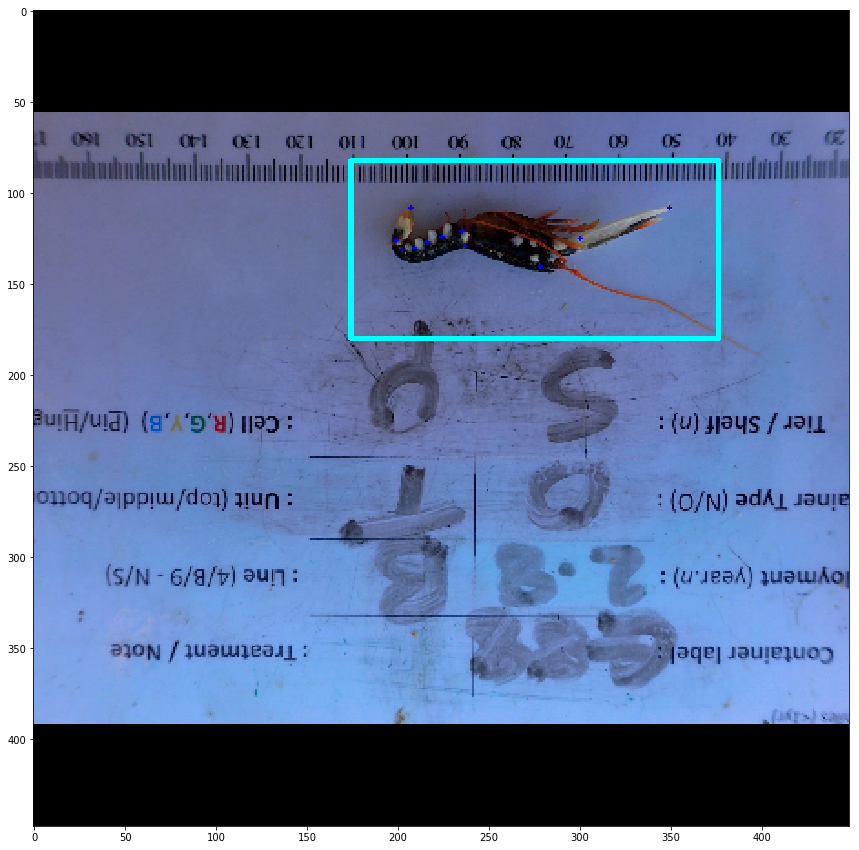

In [24]:
idx = 408
tuples = []
for i in range(11):
    tuples.append((all_landmarks[idx][i*2],all_landmarks[idx][i*2+1]))
for i in range(11):
    img = cv2.circle(all_images[idx],(int(tuples[i][0]),int(tuples[i][1])), 1, (0,0,255), -1)
    
pt1 = (int(all_bboxes[idx][0]),int(all_bboxes[idx][1]))
pt2 = (int(all_bboxes[idx][2]),int(all_bboxes[idx][3]))
img = cv2.rectangle(all_images[idx],pt1,pt2,(0,255,255),thickness=2)
pil_im = Image.fromarray(img)
plt.figure(figsize=(15,15))
plt.imshow(pil_im)

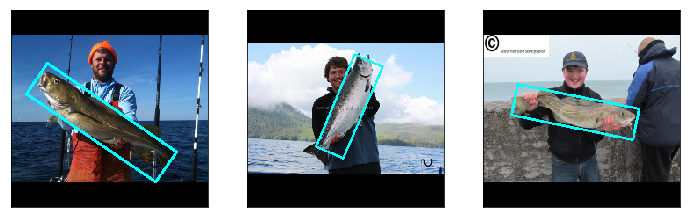

In [261]:
fig, ax = plt.subplots(figsize=(12,15))



plt.subplot(1, 3, 1)
idx = 381
point_list = []
#for keypoint in all_bboxes[idx].keypoints:
#    point_list.append([keypoint.x,keypoint.y])

point_list = [[all_bboxes[idx][0],all_bboxes[idx][1]],[all_bboxes[idx][2],all_bboxes[idx][3]],
[all_bboxes[idx][4],all_bboxes[idx][5]],[all_bboxes[idx][6],all_bboxes[idx][7]]]

pts = np.array(point_list)
pts = pts.reshape((-1,1,2))
img = cv2.polylines(all_images[idx],np.int32([pts]),thickness=2,color=(0,255,255),isClosed=True)
pil_im = Image.fromarray(img)
plt.imshow(pil_im)
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 2)
idx = 786
point_list = []
#for keypoint in all_bboxes[idx].keypoints:
#    point_list.append([keypoint.x,keypoint.y])

point_list = [[all_bboxes[idx][0],all_bboxes[idx][1]],[all_bboxes[idx][2],all_bboxes[idx][3]],
[all_bboxes[idx][4],all_bboxes[idx][5]],[all_bboxes[idx][6],all_bboxes[idx][7]]]

pts = np.array(point_list)
pts = pts.reshape((-1,1,2))
img = cv2.polylines(all_images[idx],np.int32([pts]),thickness=2,color=(0,255,255),isClosed=True)
pil_im = Image.fromarray(img)
plt.imshow(pil_im)
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 3)
idx = 1014
point_list = []
#for keypoint in all_bboxes[idx].keypoints:
#    point_list.append([keypoint.x,keypoint.y])

point_list = [[all_bboxes[idx][0],all_bboxes[idx][1]],[all_bboxes[idx][2],all_bboxes[idx][3]],
[all_bboxes[idx][4],all_bboxes[idx][5]],[all_bboxes[idx][6],all_bboxes[idx][7]]]

pts = np.array(point_list)
pts = pts.reshape((-1,1,2))
img = cv2.polylines(all_images[idx],np.int32([pts]),thickness=2,color=(0,255,255),isClosed=True)
pil_im = Image.fromarray(img)
plt.imshow(pil_im)
plt.xticks([])
plt.yticks([])

plt.savefig('rotated_bounding_boxes.jpg')
plt.show()

In [174]:
i 

72

In [256]:
bbs.keypoints[0]

Keypoint(x=187.75761159, y=208.26463522)